# CS 458 Proj 2
## Joshua Matni

Due Date: See Webcampus
How to submit: Webcampus
General Guidelines:
• Please submit the codes for all the problems in a SINGLE ipynb file with the necessary
texts to separate each problem.
• Please submit the pdf version of your ipynb file.


P2-1. (U & G-required) Decision Tree
Use the Iris dataset embedded in scikit-learn:
from sklearn import datasets
iris = datasets.load_iris()
(a) Develop a decision tree based classifier to classify the 3 different types of Iris (Setosa,
Versicolour, and Virginica). To build your classifier, you can use:
sklearn.tree.DecisionTreeClassifier
(See https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
Instructions: When training the decision tree, use 5-fold cross validation. To make your training
dataset balanced, pick 10 samples from each Iris type as test set so that the training dataset will
contain 40 samples from each Iris type. In total, you will have 120 samples in the training dataset
and 30 samples in the test dataset.
Refer to sklearn.model_selection.StratifiedKFold (https://scikit-
learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

In [1]:
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

iris = datasets.load_iris()
X, y = iris.data, iris.target

# separate out 10 samples from each class to form the test set (30 samples)
test_indices = np.hstack([np.where(y == i)[0][:10] for i in range(3)])
train_indices = np.setdiff1d(np.arange(len(y)), test_indices)

X_train, y_train = X[train_indices], y[train_indices]
X_test, y_test = X[test_indices], y[test_indices]

clf = DecisionTreeClassifier()

# 5-fold cross-validation
skf = StratifiedKFold(n_splits=5)

accuracies = []

for train_index, val_index in skf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    clf.fit(X_train_fold, y_train_fold)
    y_pred = clf.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

print(f"Average cross-validation accuracy: {np.mean(accuracies):.2f}")

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test accuracy: {test_accuracy:.2f}")


Average cross-validation accuracy: 0.96
Test accuracy: 0.97


b) Show the confusion matrix of your decision tree. Plot this decision tree.

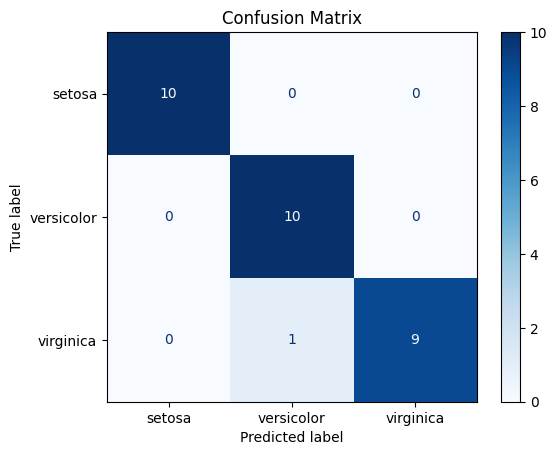

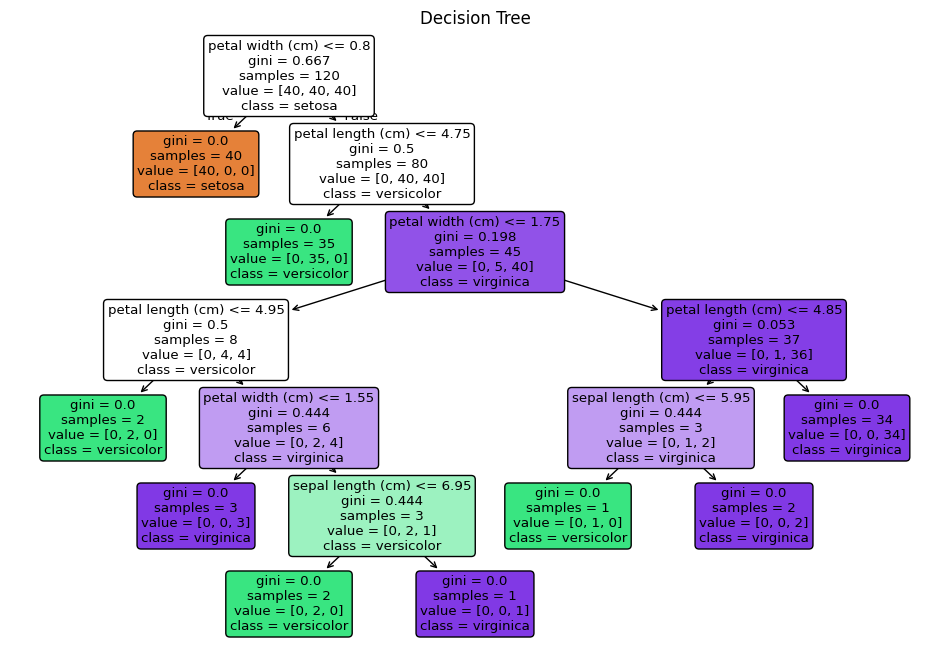

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree

# confusion matrix
y_test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(12,8))
plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names, rounded=True)
plt.title("Decision Tree")
plt.show()

P2-2. (U & G-required) Model Overfitting
Reproduce the figures in slide 61 in Chapter 3, i.e,

(a) Generate the dataset as in slide 56 in Chapter 3:

• Class 1: Generate 5000 instances following a Gaussian distribution centered at (10,10) with
covariance [2 0
0 2]. And generate 200 instances following a uniform distribution in a plane
defined by the corner points {(0,0), (0,20), (20,0), (20,20)}.

• Class 2: Generate 5200 instances following a uniform distribution in the same plane.

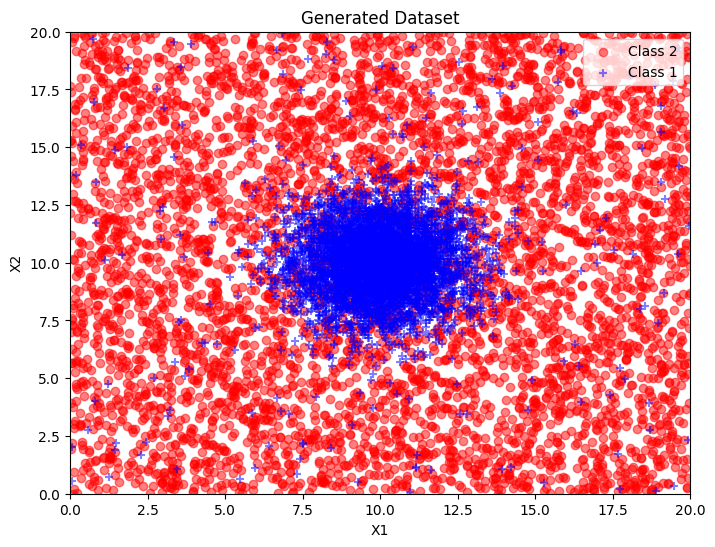

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# random seed
np.random.seed(42)

mean = [10, 10]
cov = [[2, 0], [0, 2]]  # covariance matrix
class1_gaussian = np.random.multivariate_normal(mean, cov, 5000)

# class 1: 200 points from a uniform distribution
class1_uniform = np.random.uniform(0, 20, size=(200, 2))

# class 2: 5200 points from a uniform distribution
class2_uniform = np.random.uniform(0, 20, size=(5200, 2))

class1 = np.vstack((class1_gaussian, class1_uniform))
class2 = class2_uniform

plt.figure(figsize=(8, 6))
# plot class 2 first; class 1 is on top
plt.scatter(class2[:, 0], class2[:, 1], color='red', label='Class 2', alpha=0.5, marker='o')
plt.scatter(class1[:, 0], class1[:, 1], color='blue', label='Class 1', alpha=0.5, marker='+')
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Generated Dataset')

plt.legend(loc='upper right', frameon=True)
plt.show()

(b) Randomly select 10% of the data as test dataset and the remaining 90% of the data as training
dataset. Train decision trees by increasing the number of nodes of the decision trees until the
training error becomes 0. Plot the training errors and the testing errors under different numbers of
nodes and explain the model underfitting and model overfitting

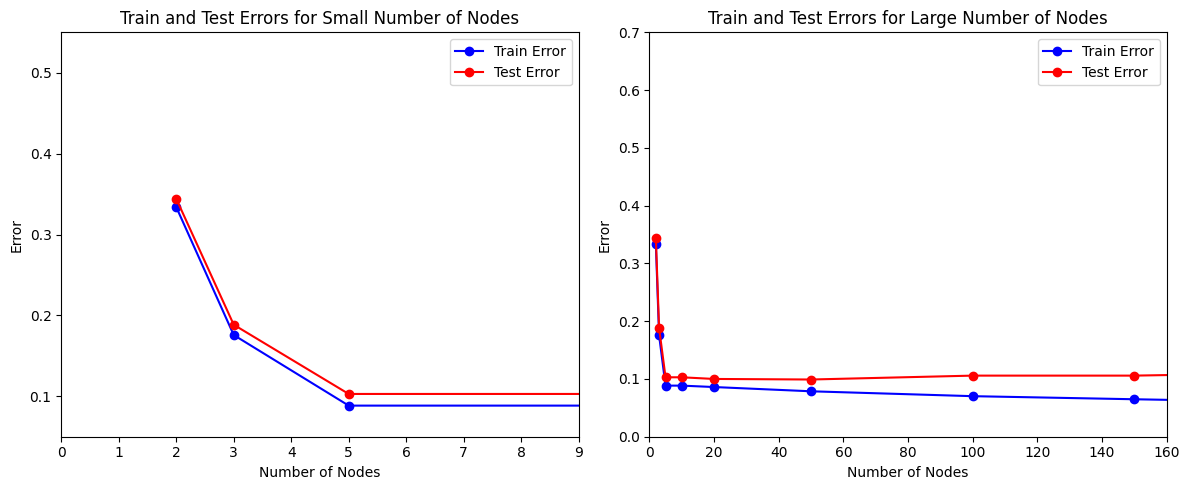

In [18]:
X = np.vstack((class1, class2))
y = np.hstack((np.ones(class1.shape[0]), np.zeros(class2.shape[0])))

# 90% training and 10% testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

max_nodes = [2, 3, 5, 10, 20, 50, 100, 150, 200]
train_errors = []
test_errors = []

for nodes in max_nodes:
    tree = DecisionTreeClassifier(max_leaf_nodes=nodes, random_state=42)
    tree.fit(X_train, y_train)

    # training and testing error
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)

    train_error = 1 - accuracy_score(y_train, y_train_pred)
    test_error = 1 - accuracy_score(y_test, y_test_pred)

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.figure(figsize=(12, 5))

# left
plt.subplot(1, 2, 1)
plt.plot(max_nodes[:10], train_errors[:10], label="Train Error", color='blue', marker='o')
plt.plot(max_nodes[:10], test_errors[:10], label="Test Error", color='red', marker='o')
plt.xlabel("Number of Nodes")
plt.ylabel("Error")
plt.title("Train and Test Errors for Small Number of Nodes")
plt.xlim(0, 9)
plt.ylim(0.05, 0.55)
plt.legend()

# right
plt.subplot(1, 2, 2)
plt.plot(max_nodes, train_errors, label="Train Error", color='blue', marker='o')
plt.plot(max_nodes, test_errors, label="Test Error", color='red', marker='o')
plt.xlabel("Number of Nodes")
plt.ylabel("Error")
plt.title("Train and Test Errors for Large Number of Nodes")
plt.xlim(0, 160)
plt.ylim(0, 0.7)
plt.legend()

plt.tight_layout()
plt.show()

Underfitting occurs when a model is too simple to capture the underlying patterns in the data, leading to high errors on both the training and test sets. In your plot, underfitting is evident when the number of nodes is low, as both the training and testing errors are high and close to each other. The model is not complex enough to learn from the data, resulting in poor performance.

On the other hand, overfitting happens when a model becomes too complex and fits the training data too closely, including noise and random variations. As seen in the plot, as the number of nodes increases, the training error decreases significantly, but the testing error begins to stabilize or increase slightly. This indicates that the model is learning specific details from the training data that do not generalize well to new, unseen data.

The ideal balance lies between these two extremes, where both training and test errors are low, indicating the model is complex enough to capture important patterns but not too complex to overfit.

P2-3. (G-required) Text Documents Classification
Use the 20 newsgroups dataset embedded in scikit-learn:
from sklearn.datasets import fetch_20newsgroups

(See https://scikit-
learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.f
etch_20newsgroups)

(a) Load the following 4 categories from the 20 newsgroups dataset: categories = ['rec.autos',
'talk.religion.misc', 'comp.graphics', 'sci.space']. Print the number of documents in the training
dataset and the test dataset. Print the number of attributes in the training dataset.

In [19]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

print(f"Number of documents in the training dataset: {len(train_data.data)}")
print(f"Number of documents in the test dataset: {len(test_data.data)}")

# countVectorizer to get the number of attributes (features) in training dataset
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(train_data.data)

print(f"Number of attributes in the training dataset: {X_train_counts.shape[1]}")


Number of documents in the training dataset: 2148
Number of documents in the test dataset: 1430
Number of attributes in the training dataset: 34948


(b) Develop a decision tree for text documents classification. Show the confusion matrix of your
decision tree.

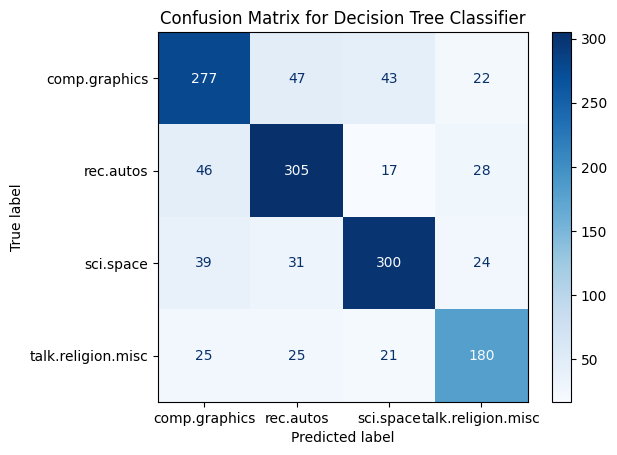

In [20]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

categories = ['rec.autos', 'talk.religion.misc', 'comp.graphics', 'sci.space']

train_data = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
test_data = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.data)
X_test = vectorizer.transform(test_data.data)

y_train = train_data.target
y_test = test_data.target

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.target_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()
